In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [ ]:
#read in clean data frame
scoreboard_df = pd.read_csv("clean_scoreboard_df.csv")
scoreboard_df.head()

,Unnamed: 0,Name,Course Name,Position,Strokes Under,Total Strokes,First Round,Second Round,Third Round,Fourth Round,Fourth Round Tee Time,Amateur Status,Tournament Status,ID
0,0,Scottie Scheffler,Le Golf National,1,-19,265,67,69,67,62,12:17:00,False,complete,46046
1,1,Tommy Fleetwood,Le Golf National,2,-18,266,67,64,69,66,12:39:00,False,complete,30911
2,2,Hideki Matsuyama,Le Golf National,3,-17,267,63,68,71,65,12:28:00,False,complete,32839
3,3,Victor Perez,Le Golf National,4,-16,268,70,67,68,63,11:55:00,False,complete,47679
4,4,Rory McIlroy,Le Golf National,5,-15,269,68,69,66,66,12:28:00,False,complete,28237


In [ ]:
#filter to just the rounds that can be used to predict the forth round
rounds_df = scoreboard_df[["Name", "Course Name", "First Round", "Second Round", "Third Round"]]
rounds_df.head()

,Name,Course Name,First Round,Second Round,Third Round
0,Scottie Scheffler,Le Golf National,67,69,67
1,Tommy Fleetwood,Le Golf National,67,64,69
2,Hideki Matsuyama,Le Golf National,63,68,71
3,Victor Perez,Le Golf National,70,67,68
4,Rory McIlroy,Le Golf National,68,69,66


In [ ]:
#create a df that shows the position after each round
df_long = rounds_df.melt(
    id_vars=["Name", "Course Name"],
    value_vars=["First Round", "Second Round", "Third Round"],
    var_name="Round",
    value_name="Score",
)

round_order = {"First Round": 1, "Second Round": 2, "Third Round": 3}
df_long["Round Number"] = df_long["Round"].map(round_order)
df_long = df_long.sort_values(["Course Name", "Round Number"])
df_long["Cumulative Score"] = df_long.groupby(["Course Name", "Name"])["Score"].cumsum()

df_long["Position"] = (
    df_long.groupby(["Course Name", "Round Number"])["Cumulative Score"]
    .rank(method="min")
    .astype(int)
)

df_wide = df_long.pivot(
    index=["Name", "Course Name"],
    columns="Round",
    values="Position",
).reset_index()

position_df = pd.merge(
    df_wide, 
    scoreboard_df[["Name","Course Name", "Position"]], 
    on=["Name", "Course Name"], 
    how="left"  
)

position_df  = position_df .sort_values(
    by=["Course Name", "Position"],
    ascending=[True, True]
).reset_index(drop=True)

position_df.rename(columns={"First Round": "First Position", "Second Round": "Second Position", "Third Round": "Third Position"}, inplace=True)

position_df .head(10)

,Name,Course Name,First Position,Second Position,Third Position,Position
0,Scottie Scheffler,Augusta National Golf Club,2,1,1,1
1,Ludvig Åberg,Augusta National Golf Club,32,7,4,2
2,Collin Morikawa,Augusta National Golf Club,14,5,2,3
3,Max Homa,Augusta National Golf Club,3,1,3,3
4,Tommy Fleetwood,Augusta National Golf Club,26,8,9,3
5,Bryson DeChambeau,Augusta National Golf Club,1,1,5,6
6,Cameron Smith,Augusta National Golf Club,14,8,9,6
7,Xander Schauffele,Augusta National Golf Club,26,15,6,8
8,Cameron Young,Augusta National Golf Club,8,8,9,9
9,Tyrrell Hatton,Augusta National Golf Club,26,24,21,9


<Axes: >

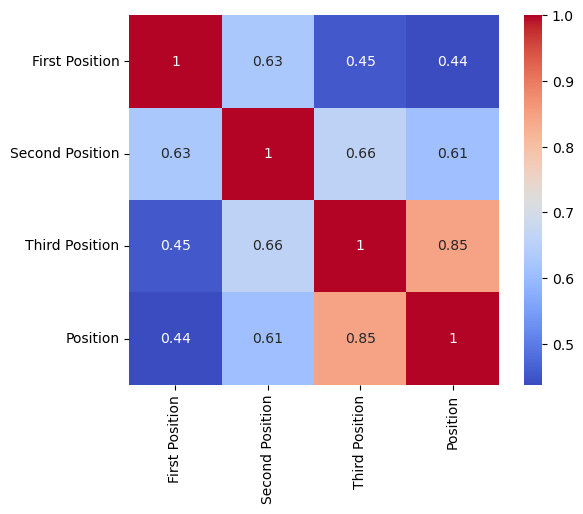

In [ ]:
#correlation plot between position between days
numeric_df = position_df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)


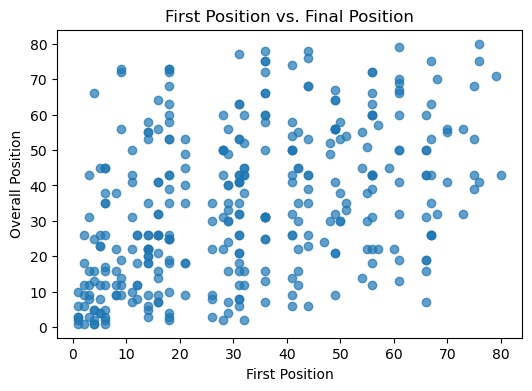

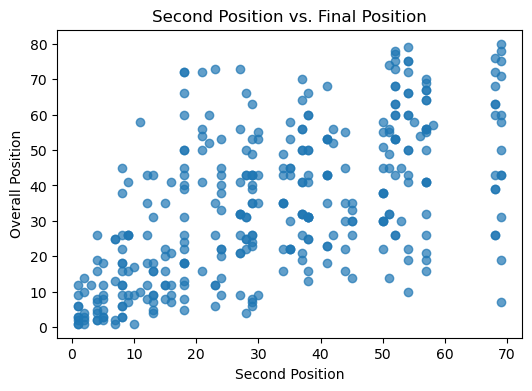

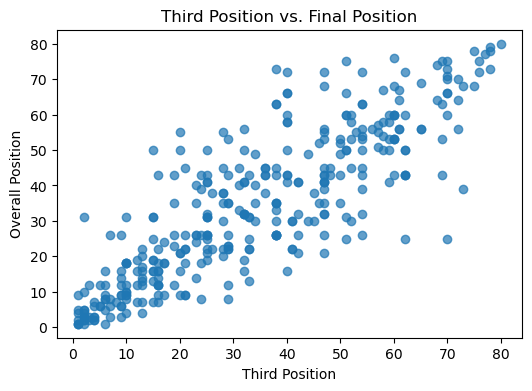

In [ ]:
#scatterplot showing the relation between round position and overall position
rounds = ["First Position", "Second Position", "Third Position"]
for round_name in rounds:
    plt.figure(figsize=(6, 4))
    plt.scatter(position_df[round_name], position_df["Position"], alpha=0.7)
    plt.xlabel(round_name)
    plt.ylabel("Overall Position")
    plt.title(f"{round_name} vs. Final Position")
    plt.show()

Best alpha: 1000.0
R² on Test Set: 0.7794480312351935


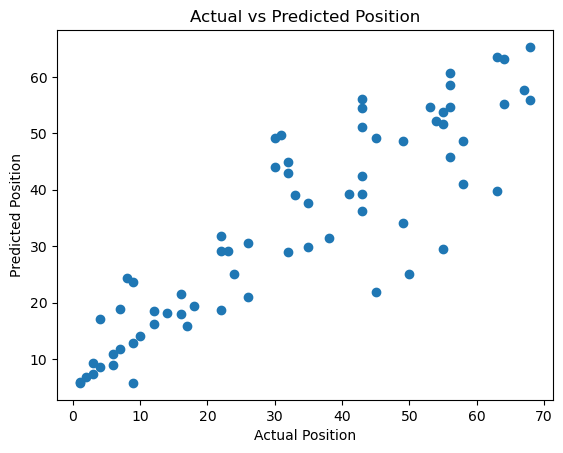

In [ ]:
#basic linear regression model
X = position_df.drop(columns=["Position", "Name", "Course Name"]) 
y = position_df["Position"]

# Split data randomly into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

alphas = np.logspace(-3, 3, 50) 

# Set up GridSearchCV for Ridge Regression
ridge = Ridge()
param_grid = {"alpha": alphas}
ridge_cv = GridSearchCV(estimator=ridge, param_grid={"alpha": alphas}, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)

# Get the best model and alpha value
best_ridge = ridge_cv.best_estimator_
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Evaluate on test set
y_pred = best_ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² on Test Set: {r2}")

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Actual vs Predicted Position")
plt.show()

R² on Test Set: 0.74897101534879


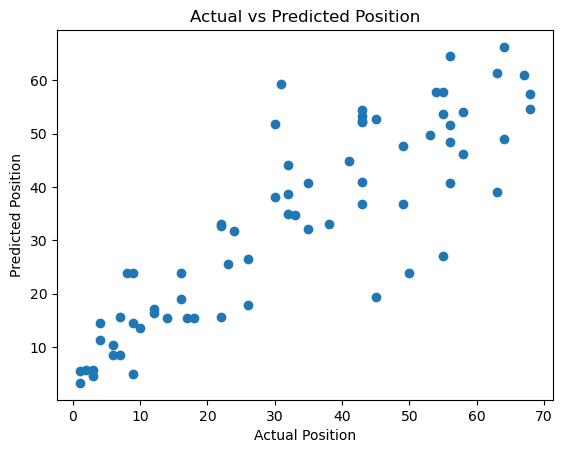

In [ ]:
#basic random forest model
X = position_df.drop(columns=["Position", "Name", "Course Name"]) 
y = position_df["Position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
print(f"R² on Test Set: {r2}")

plt.scatter(y_test, y_pred_rf)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Actual vs Predicted Position")
plt.show()

In [ ]:
#Interaction Terms to create a more informative data frame
all_df = pd.merge(
    position_df, 
    scoreboard_df[["Name","Course Name", "First Round", "Second Round", "Third Round"]], 
    on=["Name", "Course Name"], 
    how="left"  
)

all_df['First_Second_Round_Interaction'] = all_df['First Round'] * all_df['Second Round']
all_df['Second_Third_Round_Interaction'] = all_df['Second Round'] * all_df['Third Round']
all_df['First_Second_Round_Difference'] = all_df['First Round'] - all_df['Second Round']
all_df['Second_Third_Round_Difference'] = all_df['Second Round'] - all_df['Third Round']
all_df['First_Third_Round_Difference'] = all_df['First Round'] - all_df['Third Round']
all_df['First_Second_Position_Difference'] = all_df['First Position'] - all_df['Second Position']
all_df['Second_Third_Position_Difference'] = all_df['Second Position'] - all_df['Third Position']
all_df['First_Third_Position_Difference'] = all_df['First Position'] - all_df['Third Position']

all_df.head()

,Name,Course Name,First Position,Second Position,Third Position,Position,First Round,Second Round,Third Round,First_Second_Round_Interaction,Second_Third_Round_Interaction,First_Second_Round_Difference,Second_Third_Round_Difference,First_Third_Round_Difference,First_Second_Position_Difference,Second_Third_Position_Difference,First_Third_Position_Difference
0,Scottie Scheffler,Augusta National Golf Club,2,1,1,1,66,72,71,4752,5112,-6,1,-5,1,0,1
1,Ludvig Åberg,Augusta National Golf Club,32,7,4,2,73,69,70,5037,4830,4,-1,3,25,3,28
2,Collin Morikawa,Augusta National Golf Club,14,5,2,3,71,70,69,4970,4830,1,1,2,9,3,12
3,Max Homa,Augusta National Golf Club,3,1,3,3,67,71,73,4757,5183,-4,-2,-6,2,-2,0
4,Tommy Fleetwood,Augusta National Golf Club,26,8,9,3,72,71,72,5112,5112,1,-1,0,18,-1,17


R² on Test Set: 0.7669942684320666


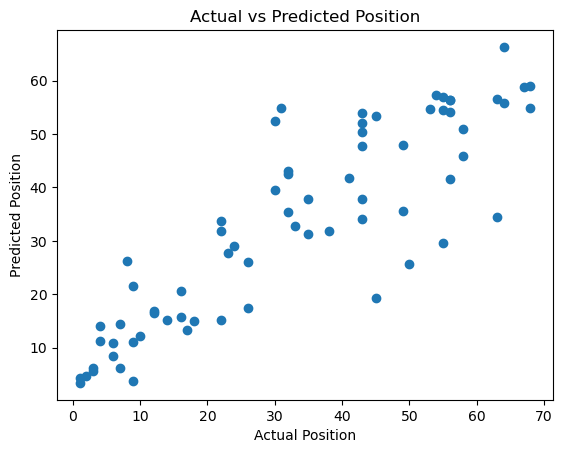

In [ ]:
#Complex Random Forest Model
X = all_df.drop(columns=["Position"]) 
y = all_df["Position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train = pd.get_dummies(X_train, columns=["Course Name", "Name"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Course Name", "Name"], drop_first=True)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_rf)
print(f"R² on Test Set: {r2}")

plt.scatter(y_test, y_pred_rf)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Actual vs Predicted Position")
plt.show()

Best alpha: 104.81131341546853
R² on Test Set: 0.7309076929095644


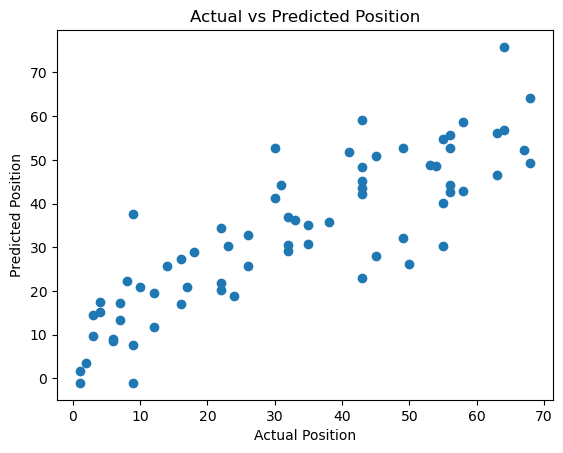

In [ ]:
#Complex Penalized Regression Model
X = all_df.drop(columns=["Position"]) 
y = all_df["Position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train = pd.get_dummies(X_train, columns=["Course Name", "Name"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Course Name", "Name"], drop_first=True)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

alphas = np.logspace(-3, 3, 50) 
ridge = Ridge()
param_grid = {"alpha": alphas}
ridge_cv = GridSearchCV(estimator=ridge, param_grid={"alpha": alphas}, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)

best_ridge = ridge_cv.best_estimator_
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

y_pred = best_ridge.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
print(f"R² on Test Set: {r2}")

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Actual vs Predicted Position")
plt.show()

